# Tutorial: Integrate two Xenium breast cancer samples

## Prepare the input .h5ad file
Download the Feature-cell Matrix (HDF5) and Cell summary file (CSV) from the Xenium breast cancer tumor microenvironment Dataset (https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast).

Then get the raw .h5ad file in jupyter with the following code

In [1]:
! mkdir ./tutorial_data
! mkdir ./tutorial_data/xenium_data
! wget -P ./tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
! wget -P ./tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz

! wget -P ./tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_cell_feature_matrix.h5
! wget -P ./tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_cells.csv.gz

! gunzip ./tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz
! gunzip ./tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep2_cells.csv.gz

--2025-11-12 23:34:47--  https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12210873 (12M) [binary/octet-stream]
Saving to: ‘./tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5’

Xenium_FFPE_Human_B 100%[===================>]  11.64M  5.51MB/s    in 2.1s    

2025-11-12 23:34:51 (5.51 MB/s) - ‘./tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5’ saved [12210873/12210873]

--2025-11-12 23:34:51--  https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com

In [5]:
import scanpy as sc
import pandas as pd

for rep in [1, 2]:
    adata = sc.read_10x_h5(f"./tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep{rep}_cell_feature_matrix.h5")
    df = pd.read_csv(f"./tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep{rep}_cells.csv")
    df.index = adata.obs_names
    adata.obs = df.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].to_numpy()
    adata.write(f"./tutorial_data/xenium_data/Rep{rep}.h5ad")

## Preparation

In [6]:
import warnings
warnings.filterwarnings("ignore")
# the location of R (used for the mclust clustering)
import os
os.environ['R_USER'] =  '/usr/lib/R'

import numpy as np
import anndata as ad
import scipy.sparse as sp
import torch

import STIntg

used_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Load Data

In [7]:
Batch_list = []
adj_list = []

section_ids = ['Rep1', 'Rep2']
for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad(f"./tutorial_data/xenium_data/{section_id}.h5ad")
    adata.layers["counts"] = adata.X.copy()

    # make spot name unique
    adata.obs_names = [x + '_' + section_id for x in adata.obs_names]

    STIntg.Cal_Spatial_Net(adata, rad_cutoff=20)

    # Normalization
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    # sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000) #ensure enough common HVGs in the combined matrix
    # adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)


Rep1
------Calculating spatial graph (PyG backend)...
The graph contains 1373672 edges, 167782 cells.
8.187 neighbors per cell on average.
Rep2
------Calculating spatial graph (PyG backend)...
The graph contains 923448 edges, 118708 cells.
7.779 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [8]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)
adata_concat.uns['edgeList'] = STIntg.adj_concat(adj_list)

adata_concat.shape:  (286490, 313)


## Running STIntg

In [9]:
spatial_net_args = {'rad_cutoff': 20, 'model': 'Radius', 'verbose': True}
adata_concat = STIntg.train(adata_concat, verbose=True, knn_neigh=50, num_batch=2,
                                device=used_device, batch_data=True, hidden_dims=[256, 128],
                                spatial_net_args=spatial_net_args,
                                pretrain_epochs=200, n_epochs=400)

------Calculating spatial graph (PyG backend)...
The graph contains 74680 edges, 41946 cells.
1.780 neighbors per cell on average.
------Calculating spatial graph (PyG backend)...
The graph contains 50216 edges, 29677 cells.
1.692 neighbors per cell on average.
------Calculating spatial graph (PyG backend)...
The graph contains 74456 edges, 41945 cells.
1.775 neighbors per cell on average.
------Calculating spatial graph (PyG backend)...
The graph contains 49740 edges, 29677 cells.
1.676 neighbors per cell on average.
------Calculating spatial graph (PyG backend)...
The graph contains 74076 edges, 41945 cells.
1.766 neighbors per cell on average.
------Calculating spatial graph (PyG backend)...
The graph contains 49678 edges, 29677 cells.
1.674 neighbors per cell on average.
------Calculating spatial graph (PyG backend)...
The graph contains 74768 edges, 41946 cells.
1.782 neighbors per cell on average.
------Calculating spatial graph (PyG backend)...
The graph contains 49768 edges, 29

100%|██████████| 200/200 [03:28<00:00,  1.04s/it, loss=1.963]


Integrate Multi-slice data with STIntg...


  0%|          | 0/200 [00:00<?, ?it/s]


No. 200 epoch update spot triplets


 50%|█████     | 100/200 [02:07<00:37,  2.66it/s, loss=2.553, mse_loss=2.420, tri_loss=0.665]


No. 300 epoch update spot triplets


100%|██████████| 200/200 [04:18<00:00,  1.29s/it, loss=2.576, mse_loss=2.453, tri_loss=0.614]


Save the embedding for downstream analysis...


## Clustering

In [10]:
sc.pp.neighbors(adata_concat, use_rep='STIntg')
sc.tl.umap(adata_concat)

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "DejaVu Sans"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 10

In [12]:
for res in [0.5, 0.6, 0.7, 0.8]:
    sc.tl.louvain(adata_concat,  resolution=res, key_added=f'louvain_{res}')
# adata_concat = sc.read_h5ad('./tutorial_data/xenium_data/Xenium_STIntg.h5ad')

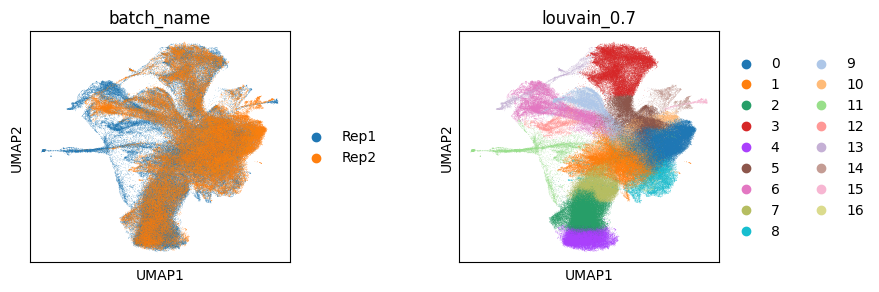

In [13]:
sc.pl.umap(adata_concat, color=['batch_name', 'louvain_0.7'], show=True, wspace=0.5)

In [14]:
section_ids = ['Rep1', 'Rep2']
Batch_list = []
for section_id in section_ids:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])


<Axes: title={'center': 'Rep2'}, xlabel='spatial1', ylabel='spatial2'>

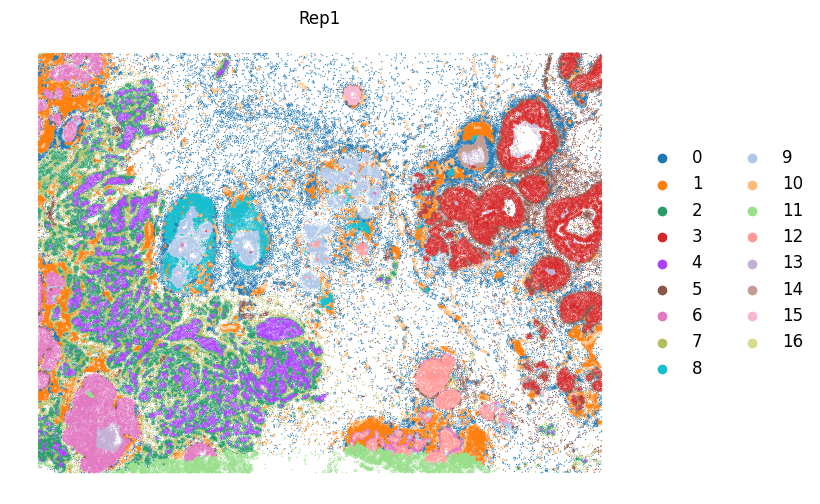

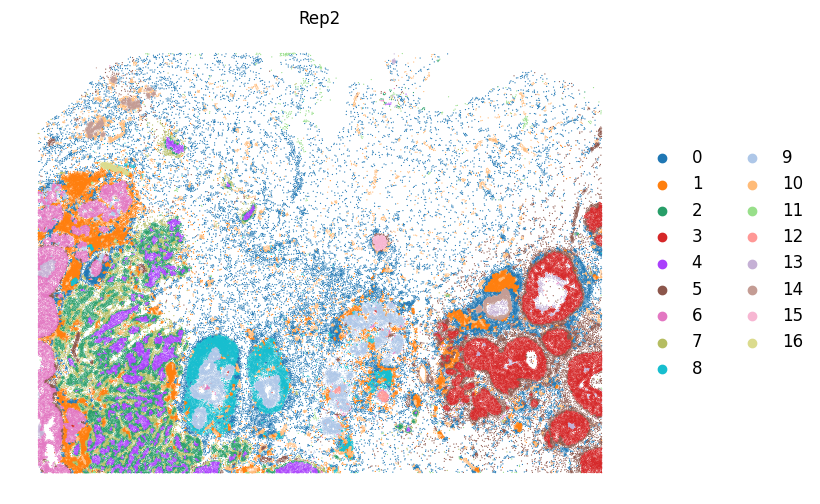

In [15]:
plt.rcParams["figure.figsize"] = (8, 6)
sc.pl.embedding(Batch_list[0],color='louvain_0.7', title=section_ids[0], basis="spatial",
                legend_fontsize=12, show=False, frameon=False, size=3)
sc.pl.embedding(Batch_list[1], color='louvain_0.7', title=section_ids[1], basis="spatial",
                legend_fontsize=12, show=False, frameon=False, size=3)